### Spiking Network Models 1
Over the previous exercises, we looked at increasingly complex compartment models but to simulate larger networks of neurons (like the fly brain) we probably want something simpler.

In theory you could generate many short `Sections`, create synaptic connections between them and model your network like that. However, `NEURON` has a special set of point processes that work better for this purpose. 

In this exercise, you will get to know integrate-and-fire point processes.

In [1]:
# The usual imports
import neuron

from neuron import h
from neuron.units import ms, mV, µm

h.load_file("stdrun.hoc")

1.0

Neuron ships with several integrate-and-fire models

In [2]:
[m for m in dir(h) if "IntFire" in str(m)]

['IntFire1',
 'IntFire2',
 'IntFire4',
 'eps_IntFire4',
 'ib_IntFire4',
 'taueps_IntFire4']

Each implements various different mechanics/parameters. Use `help()` to check their documentation:

In [3]:
help(h.IntFire1)


NEURON+Python Online Help System

Syntax:
    ``c = h.IntFire1()``


    ``c.tau --- ms time constant``


    ``c.refrac --- ms refractory period. Minimum time between events is refrac``


    ``c.m --- state variable``


    ``c.M --- analytic value of state at current time, t``


Description:
    A point process that is equivalent to an entire integrate and fire cell. 


    An output 
    spike event is sent to all the NetCon instances which have this pointprocess 
    instance as their source when m >= 1 
    If m(t0) = m0 and an input event occurs at t1 
    then the value of m an infinitesimal time before the t1 event is 
    exp(-(t1 - t0)/tau). After the input event m(t1) = m(t1) + weight where weight 
    is the weight of the NetCon event. 
    Input events are ignored for refrac time after the spike output 
    event. 


    During the refractory period,  m = 2. 
    At the end of the refractory period, m = 0. 
    During the refractory period, the function M() returns a val

Let's illustrate this using `IntFire1`. This very simple model has only two parameters:
1. The time constant (`tau`) which determines how quickly the cell returns to the resting potential.
2. The length of refractory period (`refrac`) which determines the maximal fire rate

In [4]:
# Initialize a cell
my_cell = h.IntFire1()

# Set tau and refract
my_cell.tau = 4 * ms
my_cell.refrac = 10 * ms

Next, we need a stimulus. For that we require two things:
1. A `NetStim` that fires spikes
2. A `NetCon` to connect the `NetStim` with our `IntFire1` cell

In [5]:
# Generate the stimulus
e_stims = h.NetStim()
e_stims.noise = 0.5  # this makes the spike timing random [fractional, 0-1]
e_stims.interval = 3 * ms  # interval between spikes
e_stims.start = 0 * ms  # start time of spikes
e_stims.number = 1e10  # number of spikes

# Initialize the connection between stimulus and the cell
nc = h.NetCon(e_stims, my_cell)
# `weight` effectively determines how the depolarisation in the postsynaptic cell
# - you can think of it as the product of the strength of individual synapses and the total number of synapses
nc.weight[0] = 0.5
nc.delay = 0 * ms  # the delay between presynaptic spike and postsynaptic current

Last but not least: setup the recording (which is a bit different than before)

In [6]:
stim_times = h.Vector()  # A vector for stimulus times

# We can't actually record from the stimulus itself
# Instead, we have to use a separate NetStim object
stim_times_nc = h.NetCon(e_stims, None)
stim_times_nc.record(stim_times)

# Same for recording the spikes in our cell
output_times = h.Vector()
output_times_nc = h.NetCon(my_cell, None)
output_times_nc.record(output_times)

0.0

In [7]:
# Run the simulation
h.finitialize(-65 * mV)
h.continuerun(100 * ms)

0.0

Our recordings `stim_times` and `output_times` contain time points at which 
spikes were detected:

In [8]:
stim_times.as_numpy()

array([ 0.75217529,  2.3041938 ,  5.49630909,  7.61263673,  9.83104492,
       11.4864333 , 14.08076192, 19.55809116, 23.36624339, 24.96277202,
       28.83033377, 32.42412486, 36.58023052, 39.12138103, 43.16679471,
       46.26302382, 47.82222764, 49.7431472 , 51.64706729, 55.08260633,
       58.89116363, 61.0990186 , 63.12078441, 65.88190053, 79.09860792,
       82.2798154 , 84.34903678, 86.3325891 , 89.26935279, 91.03047782,
       93.26868854, 96.06701711, 97.71548929, 99.42484217])

Show a raster plot of the output spikes and the stimulus times

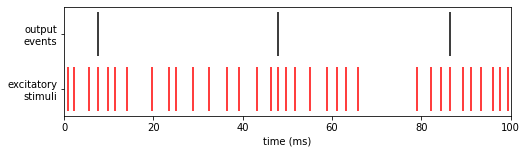

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 2))

for c, (color, data) in enumerate([("red", stim_times), ("black", output_times)]):
    ax.vlines(data.as_numpy(), c - 0.4, c + 0.4, colors=color)

ax.set_yticks([0, 1])
ax.set_yticklabels(["excitatory\nstimuli", "output\nevents"])

ax.set_xlim([0, h.t])
ax.set_xlabel("time (ms)")

We get a spikes in the postsynaptic cell but not a whole lot. 

Now you have 10min to play around with the above. Please download this notebook and run on your machine or collaboratory. Try this:

1. Play with `tau` to get more spikes
2. Reset the model and replace the synaptic current with synaptic input (`cmp.add_synaptic_input`) at 20 postsynapses (`post.node_id.unique()[0:20]`). Play with the number and interval of spikes and add try adding noise.